In [131]:
import Data_Collection as data
import numpy as np
import matplotlib.pyplot as plt

def time_series(data_dict, plot_title:str='Pressure Response'):
    plt.figure(figsize=(15, 10))
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 

    for key in data_dict['data'].keys():
        p_arr = data_dict['data'][key]['pressures']
        time_arr = data_dict['data'][key]['times']

        plt.plot(time_arr, (np.array(p_arr) - np.mean(p_arr)))

    plt.legend(data_dict['specifications']['stations'],
        bbox_to_anchor=(1.125, 1.0),
        loc='upper right', fontsize=20)

    filter_num = str(data_dict['specifications']['filter'])
    plt.title(plot_title + ' %s' % filter_num, fontsize=40)

    time_unit = str(data_dict['specifications']['units']['times'])
    plt.xlabel('Time (%s)' % time_unit, fontsize=40)

    pressure_unit = str(data_dict['specifications']['units']['pressures'])
    plt.ylabel('Pressure (%s)' % pressure_unit, fontsize=40)

def excess_path_length(data_collection, L_norm:float=2000, p_norm:float=1,
                       L_norm_units:str='mm', p_norm_units:str='bar',
                       link:bool=False):

    excess_arr = {}
    stations = data_collection['specifications']['stations']
    for i in range(len(stations)):
        for j in range(i+1, len(stations)):
            
            p_arr1 = np.array(data_collection['data'][stations[i]]['pressures']) - np.mean(data_collection['data'][stations[i]]['pressures'])
            p_arr2 = np.array(data_collection['data'][stations[j]]['pressures']) - np.mean(data_collection['data'][stations[j]]['pressures'])

            key = str(stations[i] + '-' + stations[j])
            excess_arr[key] = np.array((p_arr1 - p_arr2) * (L_norm / p_norm))

        excess_lengths = {}
        excess_lengths['specifications'] = (data_collection['specifications'])
        excess_lengths['specifications']['units'] = {'L_norm':L_norm_units,
                                               'p_norm':p_norm_units,
                                               'times':data_collection['specifications']['units']['times']}
        excess_lengths['excess_path_length'] = excess_arr
        excess_lengths['times'] = data_collection['data'][stations[0]]['times']

    return excess_lengths

def interferometric_response(data_collection, plot_title:str=None):
    fig, ax = plt.subplots(6, sharex=True, sharey=False, figsize=(10, 9))

    time_unit = data_collection['specifications']['units']['times']
    fig.supxlabel('Time (%s)' % time_unit)   

    fig.supylabel('Excess Wavelengths (deg)')

    plot_title = 'Interferometric Reponse' if plot_title == None else plot_title 
    fig.suptitle(plot_title)

    count = 0
    for stations in data_collection['excess_path_length'].keys():
        ax[count].plot(data_collection['times'], data_collection['excess_path_length'][stations]*360.0)
        
        ax[count].set_title(stations)
        count+=1

def allan_var(data_collection:dict, allan_var_units:str='Phase', delta_time:float=0.001457255920325755):

    t_arr = data_collection['times']
    t_arr = np.mean(np.diff(t_arr))

    bandwidths = {}
    for key, value in data_collection['excess_path_length'].items():
        allan_var = np.zeros(len(value))
        print("Starting data collection for " + key)

        for idx in range(1, len(value)//2):
            allan_var[idx] = np.mean((value[:-2*idx] - 2*value[idx:-idx] + value[idx*2:])**2.0) / (2.0 * (idx * t_arr) **2)

        bandwidths[key] = allan_var
    
    allan_var_dict = {}
    allan_var_dict['specifications'] = (data_collection['specifications'])
    allan_var_dict['specifications']['units'] = {'allan_var':allan_var_units,
                                                 'times':data_collection['specifications']['units']['times'],
                                                 'delta_time':delta_time}
    allan_var_dict['times'] = data_collection['times']
    allan_var_dict['allan_var'] = bandwidths

    return allan_var_dict

def plot_allan_var(data_collection:dict, title:str='Allan Variance'):
    fig,ax = plt.subplots(3, 2, figsize=(12, 17), sharey=True, sharex=True)
    fig.suptitle(title, fontsize=30)
    fig.supxlabel('Time (%s)' % data_collection['specifications']['units']['times'], fontsize=25)
    fig.supylabel('Phase', fontsize=25)

    count = 0
    for i in range(0,3):
        for j in range(0,2):
            bandwidths = list(data_collection['allan_var'].keys())
            delta_time = data_collection['specifications']['units']['delta_time']
            allan_var = data_collection['allan_var'][bandwidths[count]]

            ax[i][j].scatter(delta_time * np.arange(len(allan_var)), allan_var, label='Allan Variance', color='red')        
            ax[i][j].set_xscale('log')
            ax[i][j].set_yscale('log')
            ax[i][j].set_title(bandwidths[count], fontsize=15)
            # plot guidelines
            time_axis = delta_time * np.arange(len(allan_var))
            ax[i][j].plot(time_axis, time_axis**-2.0, label='delta_time**-2.0')
            ax[i][j].plot(time_axis, time_axis**-1.0, label='delta_time**-1.0')
            ax[i][j].plot(time_axis, time_axis**-0.5, label='delta_time**-0.5')

            ax[i][j].legend(loc='upper right', fontsize=12)
            count+=1

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.06, 
                        right=0.9, 
                        top=0.93, 
                        wspace=0.1, 
                        hspace=0.1)


In [65]:
path = '/Users/namsonnguyen/OneDrive/Pressures/filter5/Field_Experiments/'
file = 'jul25_field_boom.pkl'
new_dict = data.reformat(path, file)

#new_dict['data']['dol']['pressures']
#time_series(new_dict)

In [66]:
excess_lengths = excess_path_length(new_dict)
excess_lengths['specifications']['stations']
#interferometric_response(excess_lengths)

#excess_lengths['times']

#allan_variance = allan_var(excess_lengths)

['dol', 'ott', 'sea', 'orc']

/var/folders/w3/bj89r23n5fjgvjw9kdydq41m0000gn/T/ipykernel_17519/2755180476.py:117: RuntimeWarning: divide by zero encountered in power
  ax[i][j].plot(time_axis, time_axis**-2.0, label='delta_time**-2.0')
/var/folders/w3/bj89r23n5fjgvjw9kdydq41m0000gn/T/ipykernel_17519/2755180476.py:118: RuntimeWarning: divide by zero encountered in reciprocal
  ax[i][j].plot(time_axis, time_axis**-1.0, label='delta_time**-1.0')
/var/folders/w3/bj89r23n5fjgvjw9kdydq41m0000gn/T/ipykernel_17519/2755180476.py:119: RuntimeWarning: divide by zero encountered in power
  ax[i][j].plot(time_axis, time_axis**-0.5, label='delta_time**-0.5')


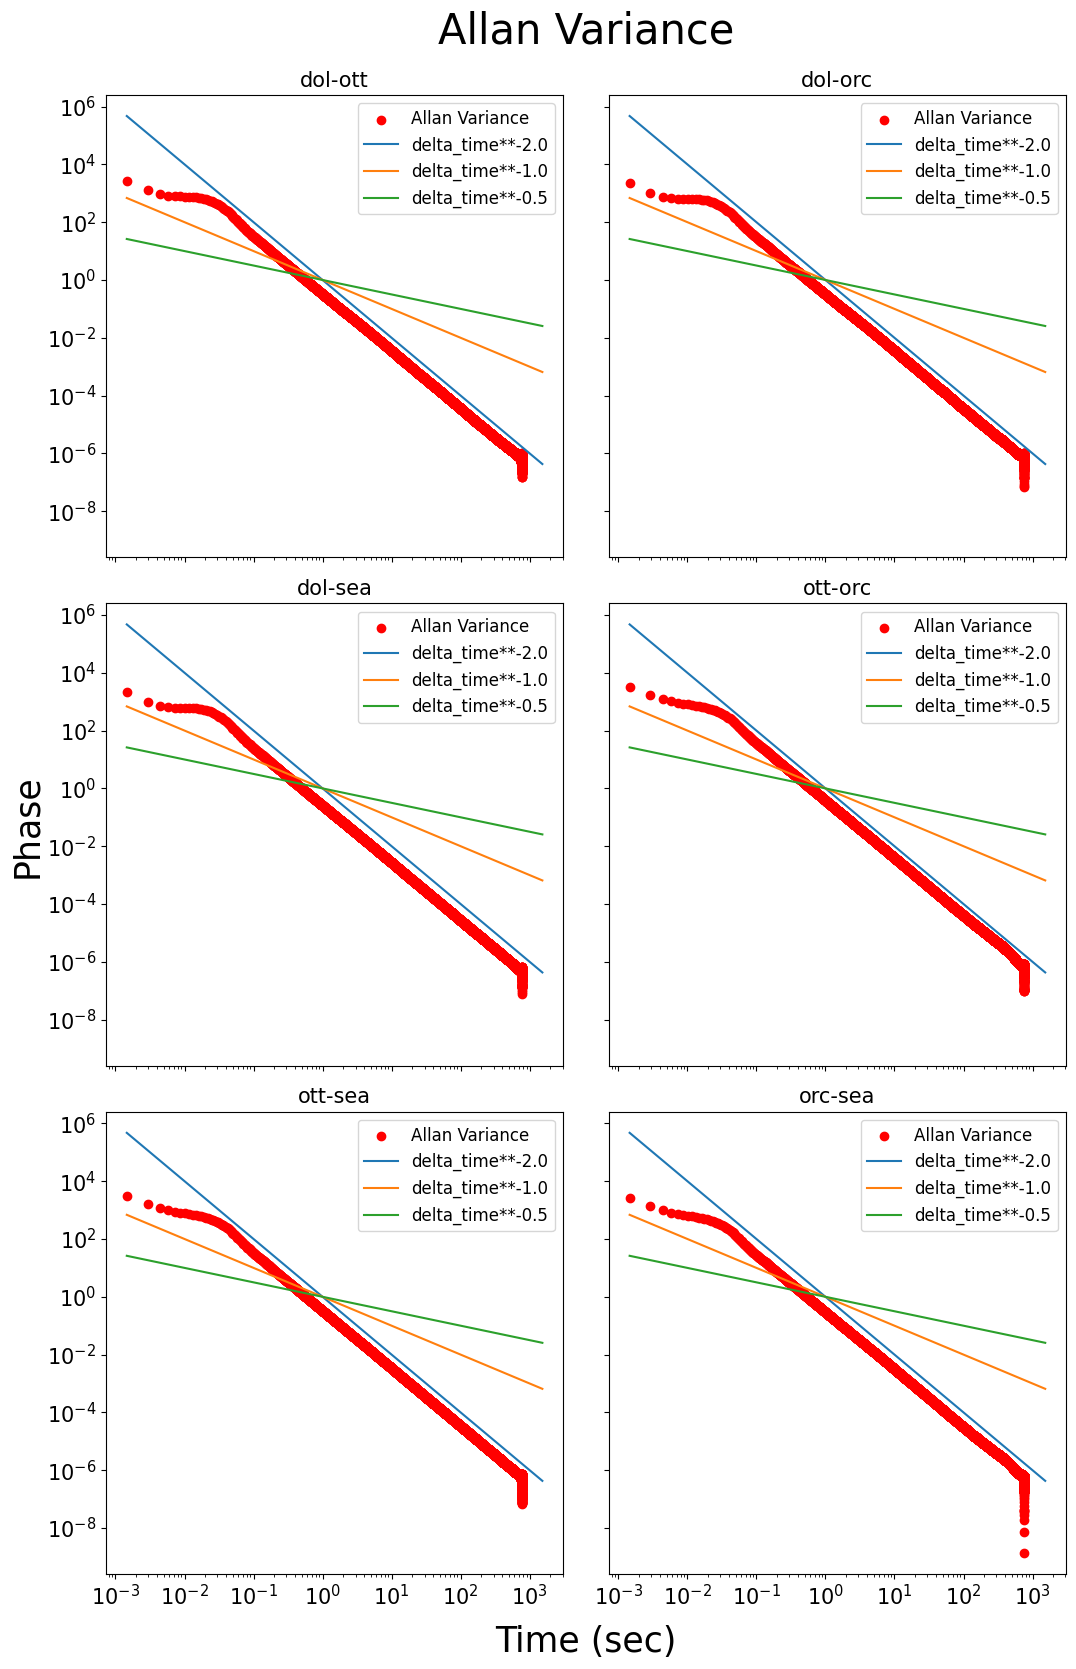

In [132]:
import Data_Collection as data

file_name = 'synced_jul19_lab_allan_var.pkl'
unformatted_allan_var = data.load(file_name)

unformatted_allan_var.keys()

formatted_allan_var = {}
formatted_allan_var['allan_var'] = unformatted_allan_var
formatted_allan_var['times'] = excess_lengths['times']
formatted_allan_var['specifications'] = excess_lengths['specifications']
formatted_allan_var['specifications']['units'] = {'allan_var':'Phase',
                                                'times':excess_lengths['specifications']['units']['times'],
                                                'delta_time':0.001457255920325755}

formatted_allan_var['specifications']['stations']

plot_allan_var(formatted_allan_var)